In [29]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [30]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [31]:
len(words)

32033

In [32]:
chars = sorted(list(set(''.join(words))))
ctoi = {c:i+1 for i,c in enumerate(chars)}
ctoi['.'] = 0
itoc = {i:c for c,i in ctoi.items()}
print(itoc)
vocab_size = len(itoc)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [33]:
# build the dataset

block_size = 3 # context length; how many characters do we need to predict the next one?
X,Y = [], []

for w in words:
    context = [0]* block_size
    for ch in w + '.':
        index = ctoi[ch]
        X.append(context)
        Y.append(index)
        #print(''.join(itoc[i] for i in context), '----->', itoc[index])
        context = context[1:] + [index] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [34]:
def build_dataset(words):
    block_size = 3 # context length; how many characters do we need to predict the next one?
    X,Y = [], []
    
    for w in words:
        context = [0]* block_size
        for ch in w + '.':
            index = ctoi[ch]
            X.append(context)
            Y.append(index)
            #print(''.join(itoc[i] for i in context), '----->', itoc[index])
            context = context[1:] + [index] # crop and append
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X,Y

import random
random.seed(42)
random.shuffle(words)
ix1 = int(0.8*len(words))
ix2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:ix1])
Xdev, Ydev = build_dataset(words[ix1:ix2])
Xte, Yte = build_dataset(words[ix2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [35]:
Xtr.shape, Xtr.dtype, Ytr.shape, Ytr.dtype

(torch.Size([182625, 3]), torch.int64, torch.Size([182625]), torch.int64)

In [36]:
# making it more respectable

In [37]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [38]:
# Let's train a deeper network

class Linear:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5 
        self.bias = torch.zeros(fan_out) if bias else None # don't play any role; compensated by beta in BatchNorm

    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])


class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained by backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained by a running 'momentum' update, not via backprop)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else: # if we're doing inference
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean)/torch.sqrt(xvar + self.eps) # BatchNorm to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training: 
            with torch.no_grad(): # since we're not going to need the gradient of these two buffers
                self.running_mean = (1-self.momentum)* self.running_mean + self.momentum * xmean
                self.running_var = (1-self.momentum)* self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
        
n_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 100 # size of the hidden layer
g = torch.Generator().manual_seed(2147483647)

# initializing the parameters
C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden),BatchNorm1d(n_hidden),  Tanh(),
    # Linear(           n_hidden, n_hidden),BatchNorm1d(n_hidden),  Tanh(),
    # Linear(           n_hidden, n_hidden),BatchNorm1d(n_hidden),  Tanh(),
    # Linear(           n_hidden, n_hidden),BatchNorm1d(n_hidden),  Tanh(),
    # Linear(           n_hidden, n_hidden),BatchNorm1d(n_hidden),  Tanh(),
    Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size)
]

with torch.no_grad(): # just initialization; not actually updating the weights via SGD
    layers[-1].gamma *= 0.1 # last layer => make softmax less confident
    # all the other layers -> apply kaimit gain
    for layer in layers:
        if isinstance(layer, Linear):
            layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
#p2 = [C] + [layer.parameters() for layer in layers] # this a list of lists of parameters, not a list of parameters; that's why needed the double comprehension to unpack
for p in parameters:
    p.requires_grad = True

6351


In [39]:
# same optimization as last time

max_steps = 100000
num_samples = 64
lossi = []
ud = []

for i in range(max_steps):
    # construct mini-batch
    ix = torch.randint(0, Xtr.shape[0], (num_samples, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # mini batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(Xb.shape[0], -1) # = embcat
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb)

    # backward pass
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    if i < 50000:
        lr = 0.1
    elif i < 150000:
        lr = 0.05
    else:
        lr = 0.01 

    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i%10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters]) # adding the update:data ratio for each of the layers' parameters 
        
    # if i>1000:
    #      break


      0/ 100000: 3.2980
  10000/ 100000: 2.2897
  20000/ 100000: 2.0620
  30000/ 100000: 2.3226
  40000/ 100000: 2.0757
  50000/ 100000: 2.0696
  60000/ 100000: 2.0749
  70000/ 100000: 2.3486
  80000/ 100000: 2.0504
  90000/ 100000: 2.2054


layer 0 (Linear): mean -0.00, std 0.00, saturated: 0.00%
layer 3 (Linear): mean 0.00, std 0.00, saturated: 0.00%


Text(0.5, 1.0, 'Activation Distribution')

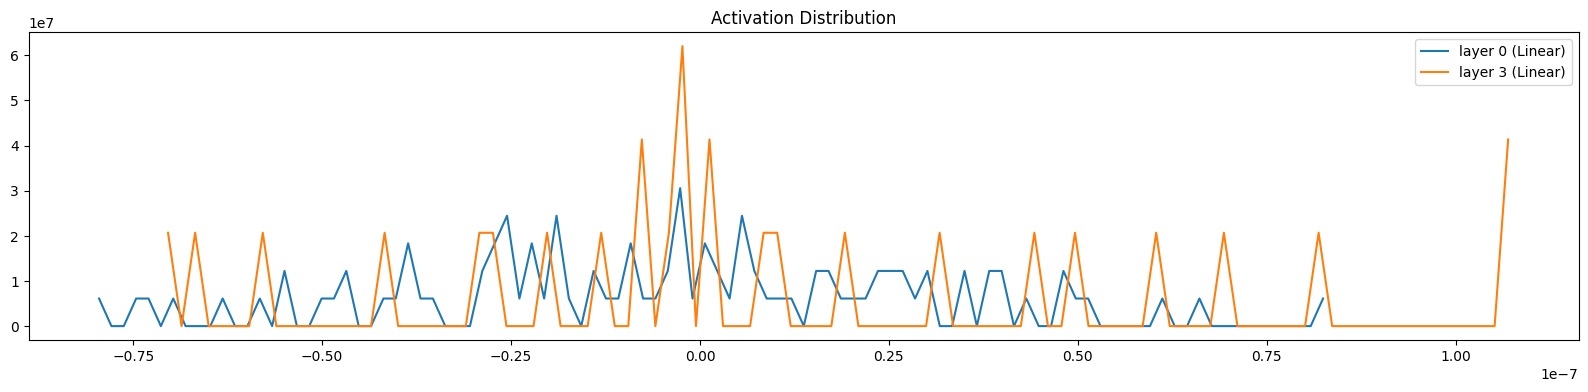

In [40]:
#visualize histograms
plt.figure(figsize=(20,4)) # width(x) and height(y) of the plot
legends = []
for i, layer in enumerate(layers): # exclude the last layer
    if isinstance(layer, Linear):
        t = layer.bias
        print('layer %d (%s): mean %.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs()>0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True) # returns Y and X in that order
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title("Activation Distribution")

Text(0.5, 1.0, 'Gradient Distribution')

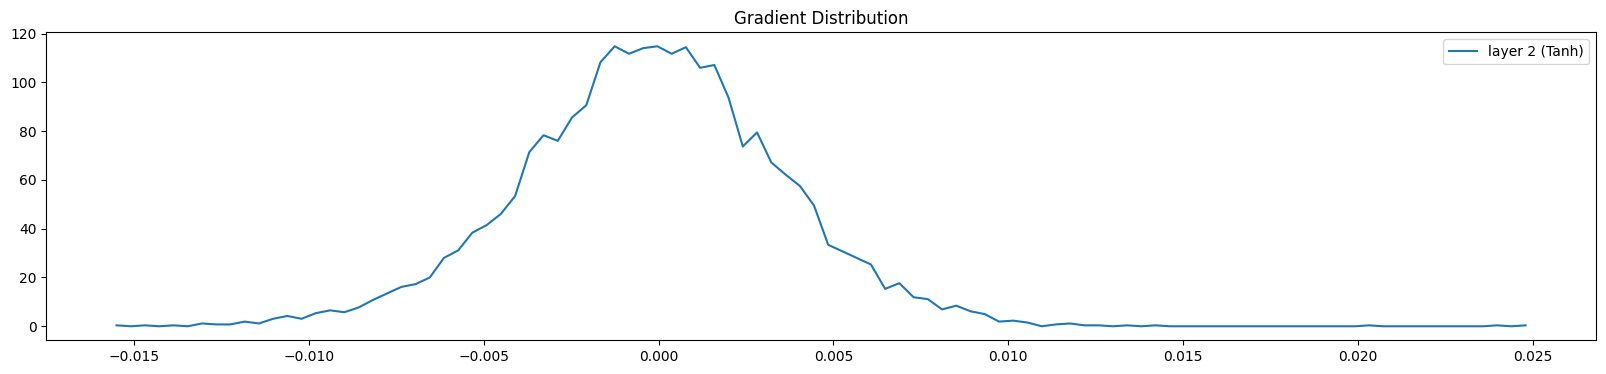

In [41]:
#visualize histograms
plt.figure(figsize=(20,4)) # width(x) and height(y) of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # exclude the last layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        #print('layer %d (%s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True) # returns Y and X in that order
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title("Gradient Distribution") # we want the gradients of all the layers to roughly be the same
# read the gradients from layer 4 to layer 0, since this is a backward pass

weight   (27, 10) | mean -0.000000 | std 1.268642e-02 | grad:data ratio 1.226135e-02
weight  (30, 100) | mean -0.000054 | std 1.174156e-02 | grad:data ratio 2.938105e-02
weight  (100, 27) | mean -0.000502 | std 1.163535e-02 | grad:data ratio 3.598170e-02


Text(0.5, 1.0, 'Weights Gradient Distribution')

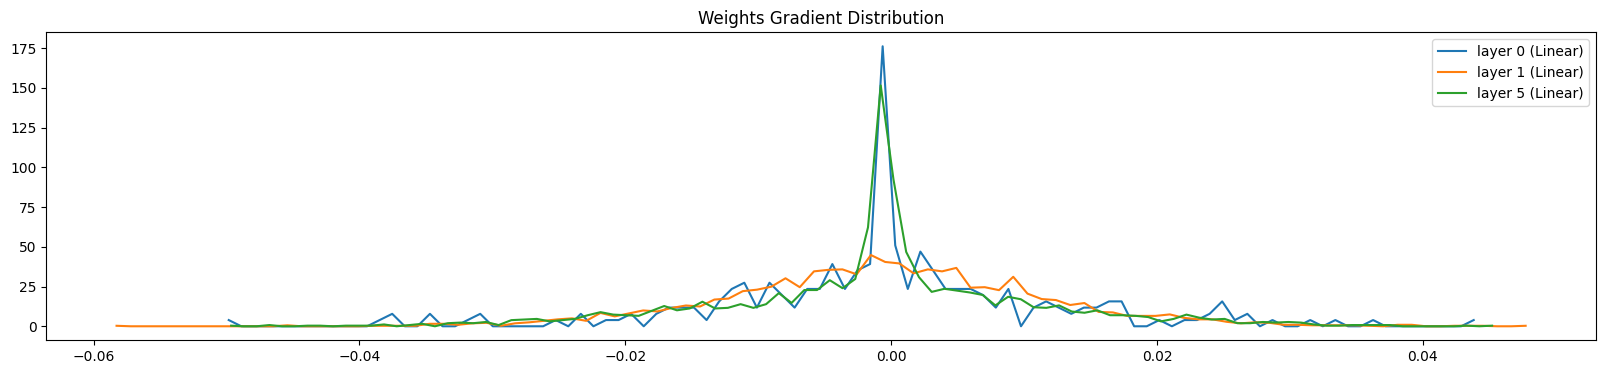

In [42]:
plt.figure(figsize=(20,4)) 
legends = []
for i, p in enumerate(parameters): 
    t = p.grad
    if p.ndim == 2: # include only the weights, not the biases
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std()/p.std()))
        hy, hx = torch.histogram(t, density=True) # returns Y and X in that order
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends);
plt.title("Weights Gradient Distribution")

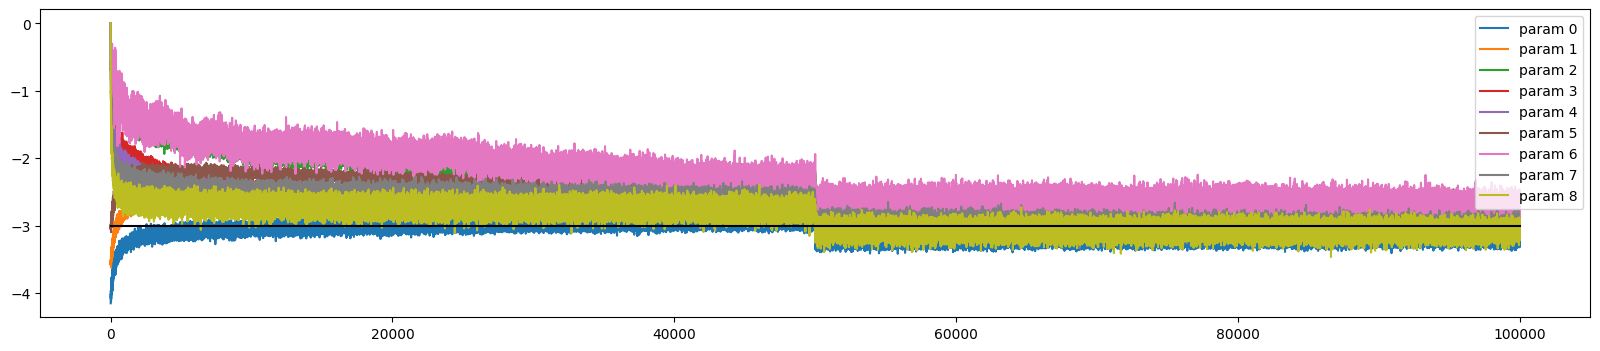

In [43]:
plt.figure(figsize=(20,4)) 
legends = []
for i, p in enumerate(parameters): 
    if p.ndim == 1 or 2: # only the weights
        plt.plot([ud[j][i] for j in range(len(ud))]) # plot of the parameters over time; by default range(len(ud)) is the x-axis of the plot
        legends.append('param %d' % i)

plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be around 1e-3; indicated on plot
plt.legend(legends);

In [44]:
class Linear_inference:

    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.zeros((fan_in, fan_out), generator=g) / fan_in**0.5 
        self.bias = torch.zeros(fan_in, fan_out) if bias else None # don't play any role; compensated by beta in BatchNorm

    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([self.bias] if self.bias is not None else [])

In [45]:
with torch.no_grad():
    layers_inference = []
    for layer in layers:
        if isinstance(layer, Linear):
            print(layers.index(layer) + 1)
            gamma = layers[layers.index(layer) + 1].gamma
            beta = layers[layers.index(layer) + 1].beta
            running_mean = layers[layers.index(layer) + 1].running_mean # final running mean after all the traning is done
            running_var = layers[layers.index(layer) + 1].running_var
            eps = layers[layers.index(layer) + 1].eps
            layer.weight *= gamma / torch.sqrt(running_var + eps)
            layer.bias = layer.bias*(gamma / torch.sqrt(running_var + eps)) + beta - (gamma*running_mean / torch.sqrt(running_var + eps))
            layers_inference.append(layer)
        elif isinstance(layer, Tanh):
            layers_inference.append(layer)

1
4


In [46]:
# with torch.no_grad():
#     layers_inference_bn = []
#     for layer in layers:
#         if isinstance(layer, Linear):
#             print(layers.index(layer) + 1)
#             gamma = layers[layers.index(layer) + 1].gamma
#             beta = layers[layers.index(layer) + 1].beta
#             running_mean = layers[layers.index(layer) + 1].running_mean
#             running_var = layers[layers.index(layer) + 1].running_var
#             eps = layers[layers.index(layer) + 1].eps
#             shape = layer.weight.shape[1]
#             layer_bn = Linear_inference(1, shape)
#             layer_bn.weight += (gamma / torch.sqrt(running_var + eps))
#             layer_bn.bias +=  beta - (gamma*running_mean / torch.sqrt(running_var + eps))
#             layers_inference_bn.append(layer)
#             layers_inference_bn.append(layer_bn)
                                      
#         elif isinstance(layer, Tanh):
#             layers_inference_bn.append(layer)

In [47]:
layers[0].bias # essentially zero
layers[3].bias # still mean 0, but has some variance

tensor([[ 0.8030,  2.8433, -0.7479, -0.5612,  0.3195,  2.8242, -1.8583, -1.7364,
          0.8059,  2.4499, -0.7383, -0.6887,  1.1933, -0.2091,  1.6426,  1.6110,
         -1.9388, -2.5042,  1.0861,  1.0615,  1.0157,  0.6479, -0.8683, -2.0220,
         -1.3412,  1.5771, -0.9675]])

In [48]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    X,Y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split] # indexing into a dictionary


    # forward pass
    emb = C[X] # embed the characters into vectors
    x = emb.view(X.shape[0], -1) # = embcat
    for layer in layers_inference:
        x = layer(x)
    loss = F.cross_entropy(x, Y)
    print(f"{split} {loss.item()}")
    
split_loss('train')
split_loss('val')

train 2.1188912391662598
val 2.1438918113708496


In [24]:
# Applying the entire set of layers during inference (including batchnorm)
#train 2.0973801612854004
#val 2.1310386657714844
# with the gamma and beta "folded" into the weights and biases of the linear layer
# train 2.101898670196533
# val 2.1311604976654053

# very similar but not quite the same result!

In [25]:
layers[3].weight

tensor([[-0.1866,  0.2863,  0.1033,  ..., -0.2638,  0.1129,  0.0142],
        [-0.3440,  0.0276,  0.0907,  ..., -0.2225,  0.0667,  0.4511],
        [-0.0997,  0.0642,  0.0341,  ...,  0.1559,  0.0602, -0.5041],
        ...,
        [-0.2467,  0.0666,  0.3790,  ...,  0.5448,  0.3150,  0.0784],
        [ 0.1851, -0.1464, -0.0643,  ..., -0.4171,  0.0122, -0.0008],
        [ 0.2872, -0.1535, -0.3443,  ...,  0.2437, -0.0312, -0.5235]],
       requires_grad=True)

In [196]:
len(ud)

1002

In [29]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      # forward pass the neural net
      emb = C[torch.tensor([context])] # (1,block_size,n_embd)
      x = emb.view(emb.shape[0], -1) # concatenate the vectors
      for layer in layers_inference:
        x = layer(x)
      logits = x
      probs = F.softmax(logits, dim=1)
      # sample from the distribution
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      # shift the context window and track the samples
      context = context[1:] + [ix]
      out.append(ix)
      # if we sample the special '.' token, break
      if ix == 0:
        break
    
    print(''.join(itoc[i] for i in out)) # decode and print the generated word

carlah.
amille.
khi.
mili.
thty.
skanden.
jazhuel.
delynn.
jarqui.
ner.
kia.
chaiir.
kaleigh.
ham.
joce.
quint.
shon.
raiviani.
waythoniearistin.
jenni.


In [27]:
probs

tensor([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan]], grad_fn=<SoftmaxBackward0>)